In [1]:
import numpy as np
from matplotlib import pyplot as plt
from astropy.cosmology import Planck18
from scipy.special import erf, erfc,erfcx
import scipy
import emcee
import corner
from astropy.table import Table
from astropy.io import fits
import fitsio
import matplotlib as mpl
from multiprocessing import Pool
from scipy.stats import dirichlet

In [2]:
k = Table.read('/pscratch/sd/z/zhaozhon/DATASET/DESI-data/k.csv',format='csv')
indice = np.isnan(k['k_gg']) | np.isinf(k['k_gg']) | np.isnan(k['k_rr']) | np.isinf(k['k_rr'])
k_gg = k['k_gg'][~indice]
k_rr = k['k_rr'][~indice]

In [3]:
file = '/pscratch/sd/z/zhaozhon/DATASET/DESI-data/new_d.fits'
d = Table(fitsio.read(file))
SEL = np.where((d['Z'] > 2.1) & (d['Z'] < 2.8))[0]
apr_mag_g = d['APP_MAG_G'][SEL][~indice]
apr_mag_g_err = d['APP_MAGERR_G'][SEL][~indice]
apr_mag_r = d['APP_MAG_R'][SEL][~indice]
apr_mag_r_err = d['APP_MAGERR_R'][SEL][~indice]
z = d['Z'][SEL][~indice]
d = Planck18.distmod(z).value

In [4]:
def log_likelihood(params, apr_mag1, magerr1, k1, apr_mag2, magerr2, k2,d, m_lim):
    sigma_I1,M_X1,a1 = params[:3]
    sigma_I2, M_X2,a2 = params[3:6]
    A_x = params[6:apr_mag1.shape[0]+6]
    mean_A_penalty = np.sum((np.mean(A_x))**2) * 1e6

    term1 = -0.5*np.log(magerr1**2+sigma_I1**2)
    term3 = -0.5 * (apr_mag1 - d - k1 -M_X1+a1*A_x )**2 / (magerr1**2+sigma_I1**2)    

    term5 = -0.5*np.log(magerr2**2+sigma_I2**2)
    term7 = -0.5 * (apr_mag2 - d - k2 - M_X2+a2*A_x )**2 / (magerr2**2+sigma_I2**2)

    term9 = -0.5*(sigma_I1-sigma_I2)**2
    total_log_likelihood = np.sum(term1+ term3  + term5+ term7+term9-mean_A_penalty)
    return total_log_likelihood

In [5]:
def sample_simplex_centered(N):
    # Sample B from a symmetric Dirichlet distribution (Simplex)
    B = dirichlet.rvs([1]*N)[0]  # rvs generates samples, [1]*N makes it uniform

    # Compute A such that the mean of A is zero
    A = B - 1/N
    
    return B, A
#B, A = sample_simplex_centered(apr_mag_g.shape[0])
B, A = sample_simplex_centered(1000)

In [6]:
def log_prior(params):
    #params = np.arange(6+apr_mag_g.shape[0]+6)
    params = np.arange(6+1000)
    sigma_I1,M_X1,sigma_I2,M_X2 = params[0],params[1],params[3],params[4]
    if 0 < sigma_I1 < 10 and -30 < M_X1 < -20 and 0 < sigma_I2 < 10 and -30 < M_X2 < -20:  # Example ranges, adjust as necessary
        return 0.0  # log(1) for uniform prior
    return -np.inf  # log(0) outside the prior ranges

# Define the log posterior
def log_posterior(params, apr_mag1, magerr1, k1,apr_mag2, magerr2, k2,d, m_lim):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, apr_mag_g, apr_mag_g_err, k_gg,apr_mag_r,
                           apr_mag_r_err, k_rr,d,22.5)

ndim = 6+1000
#ndim = 6+apr_mag_g.shape[0]  # Number of parameters
nwalkers = 2*ndim # Number of MCMC walkers
nsteps = 2000  # Number of MCMC steps
start_pos = np.hstack(([0.5, -25,1,0.5,-25,1],A)) +  np.random.randn(nwalkers, ndim)

# Using multiprocessing pool
with Pool(processes=1) as pool:
    sampler_gg = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(apr_mag_g[:1000], apr_mag_g_err[:1000], k_gg[:1000],apr_mag_r[:1000],
                        apr_mag_r_err[:1000], k_rr[:1000],d,22.5), pool=pool)
   # sampler_gg = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(apr_mag_g, apr_mag_g_err, k_gg,apr_mag_r,
                           #apr_mag_r_err, k_rr,d,22.5), pool=pool)
    sampler_gg.run_mcmc(start_pos, nsteps, progress=True)

# Get the samples, discarding the burn-in
samples_gg = sampler_gg.get_chain(discard=500, flat=True)
print(samples_gg)

  0%|          | 0/2000 [00:00<?, ?it/s]/global/homes/z/zhaozhon/.local/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 2000/2000 [02:04<00:00, 16.10it/s]

[[ -0.80595647 -23.86641443   2.08647578 ...  -1.953562    -0.65690137
    0.67156561]
 [  0.53825774 -25.79484614   0.13506339 ...   0.03546649  -1.47800774
    0.18330956]
 [  0.85216135 -27.5265091    0.39449637 ...   0.52642246  -0.59473912
    1.52481919]
 ...
 [ -0.96985831 -25.48138824   0.16304962 ...  -1.13618469  -0.56206614
   -0.52735244]
 [  1.19095912 -25.35375907   0.66035621 ...   0.09920633  -1.18288234
   -0.23603199]
 [  1.26936556 -22.94111728   1.86977149 ...   0.59045093   0.14692888
   -1.19496984]]


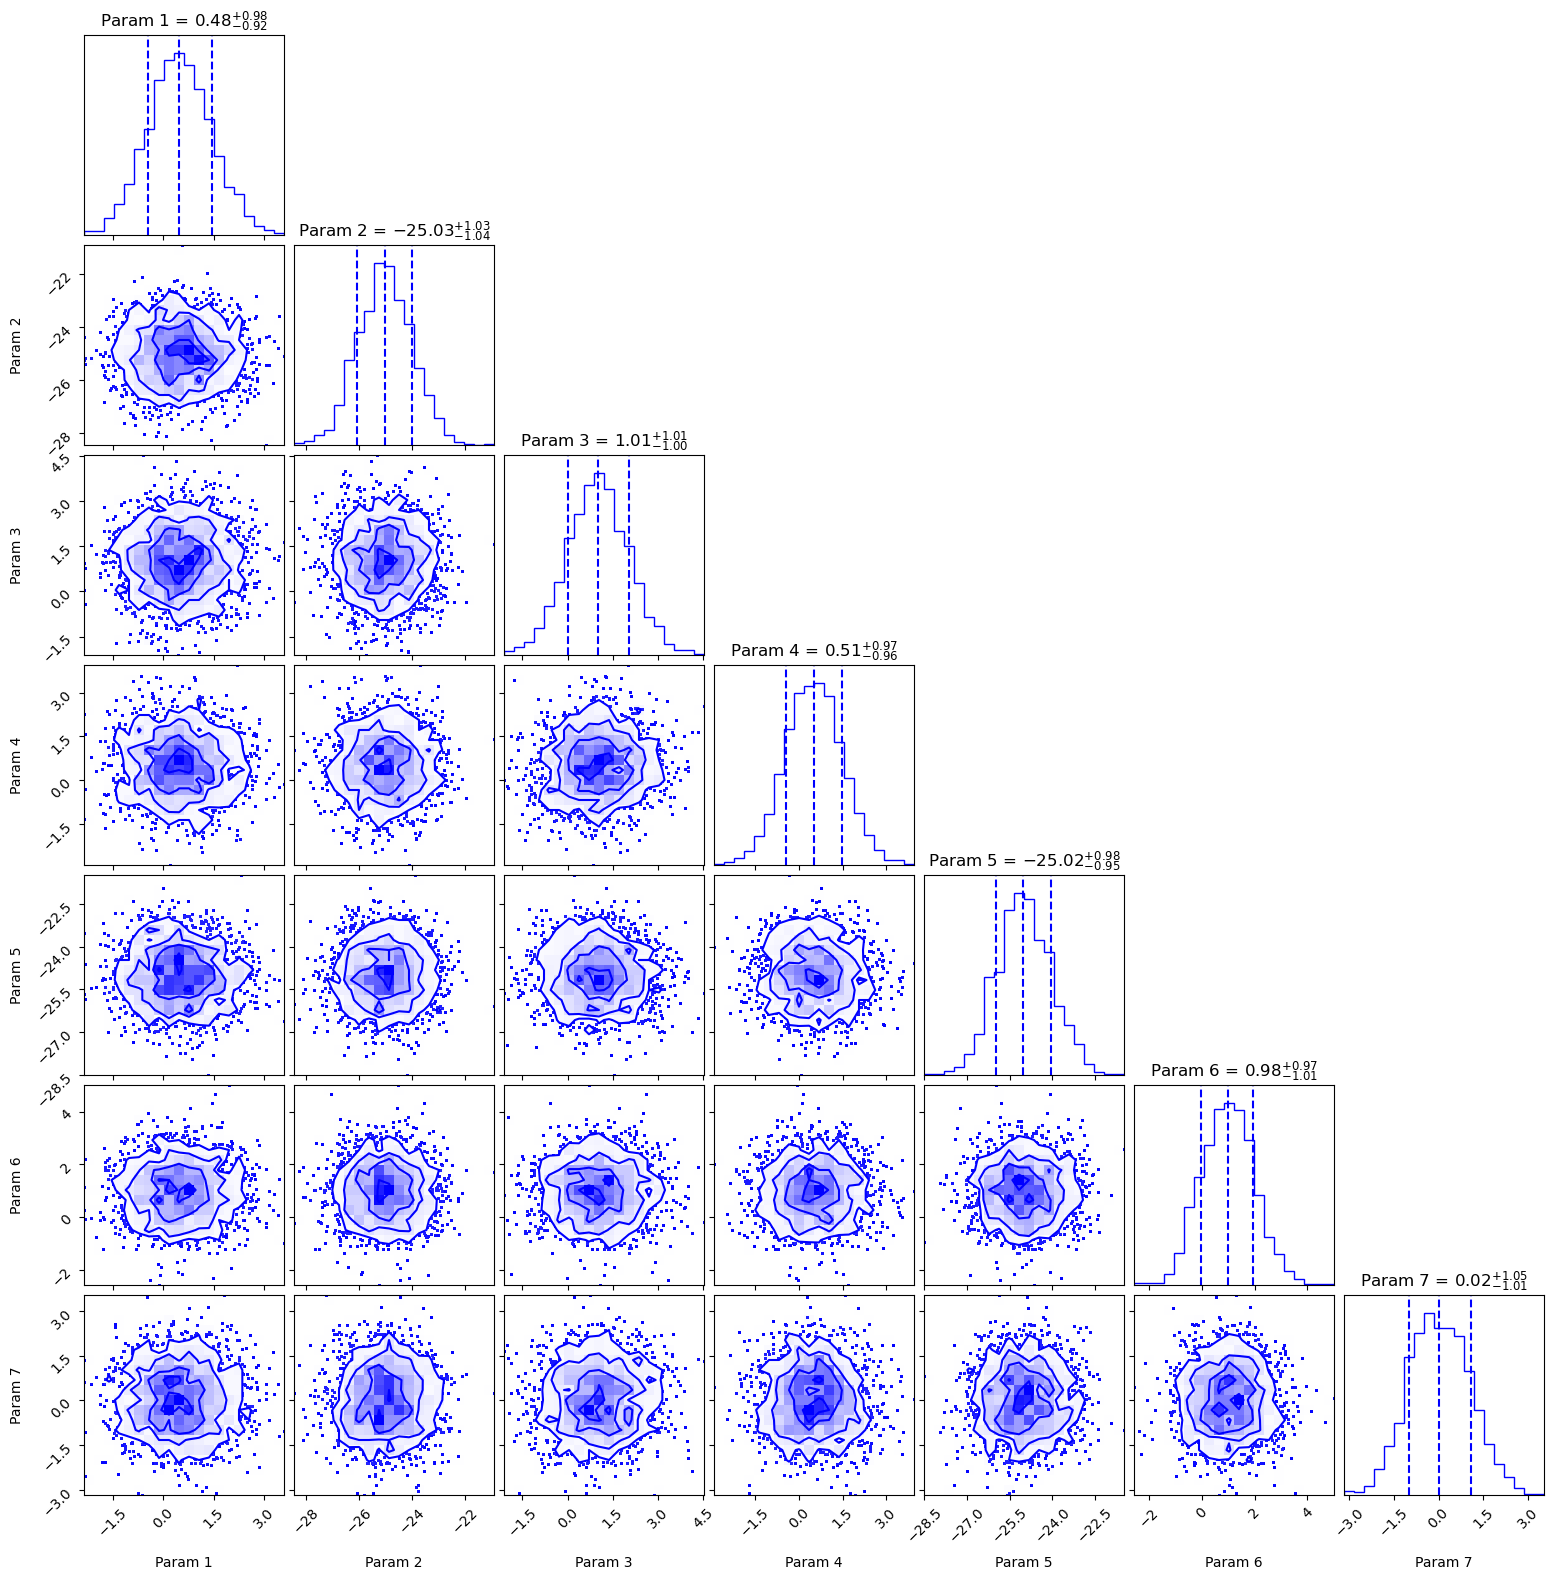

In [7]:
figure = corner.corner(samples_gg[:, :7], labels=[f'Param {i+1}' for i in range(7)],
                       show_titles=True, title_fmt='.2f', quantiles=[0.16, 0.5, 0.84],
                       plot_contours=True, color='blue', title_kwargs={"fontsize": 12})
plt.show()

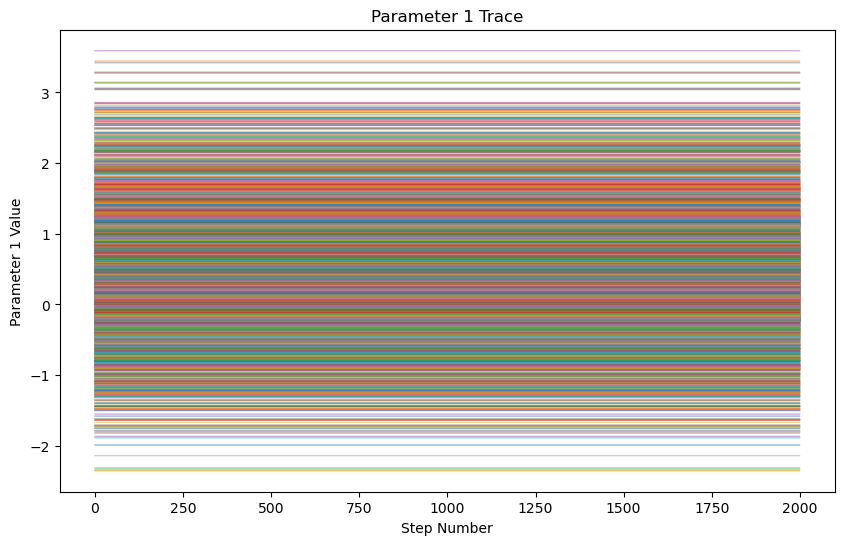

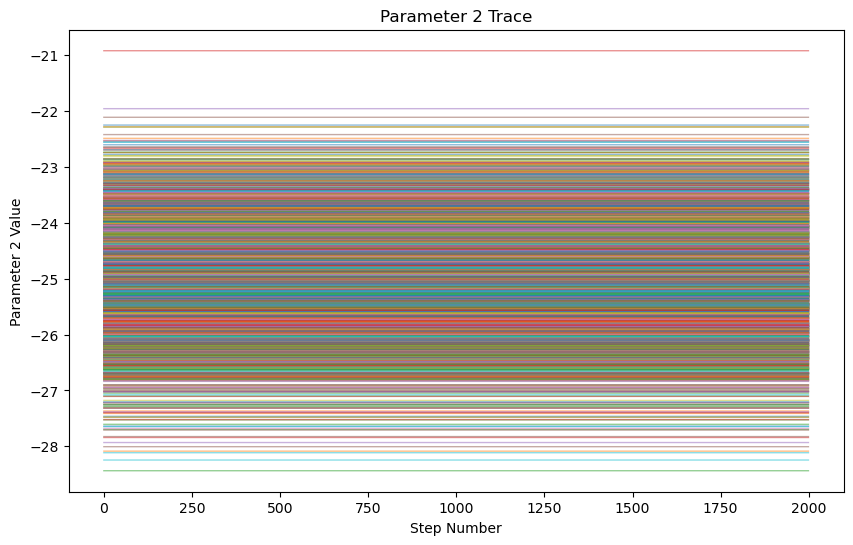

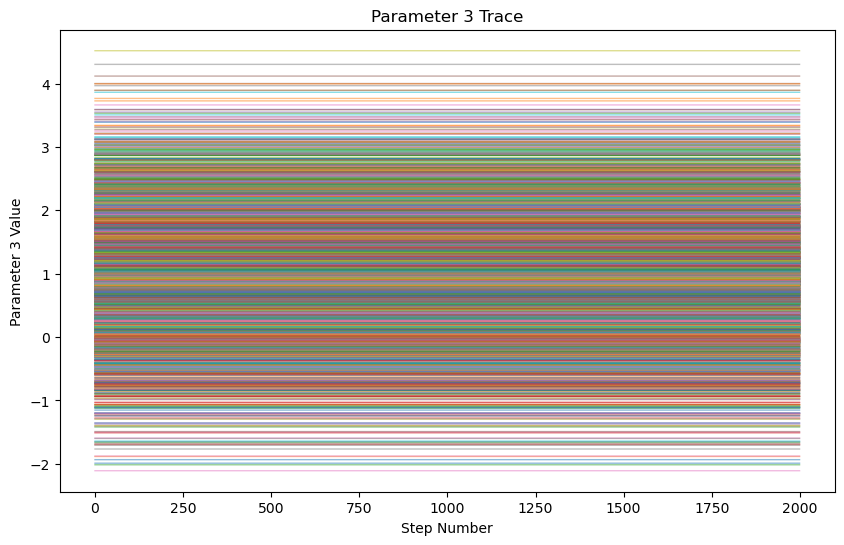

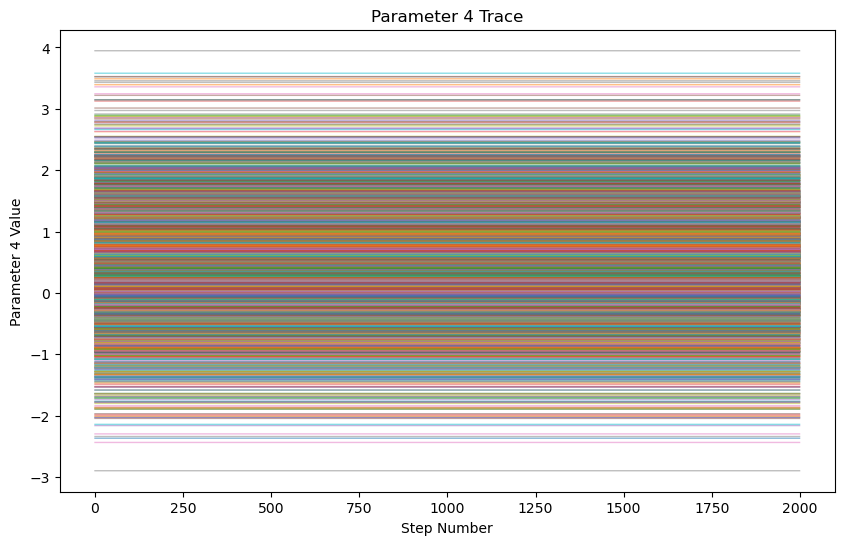

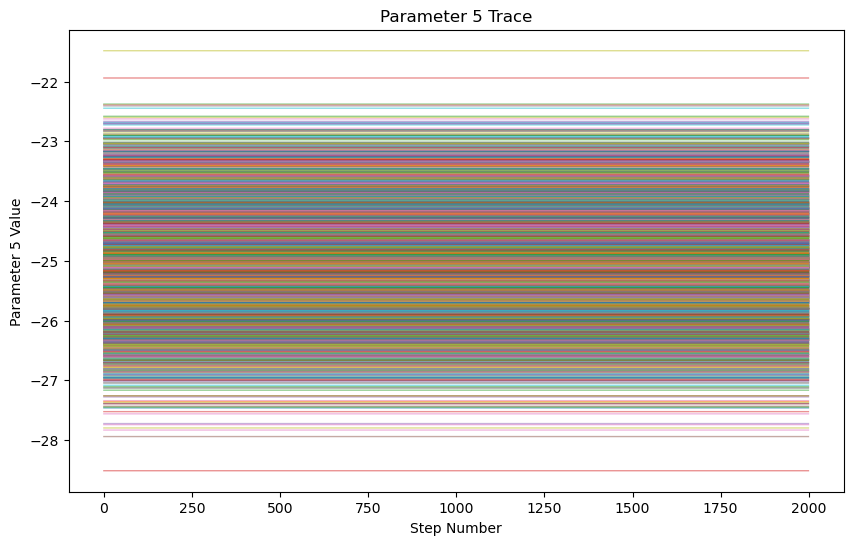

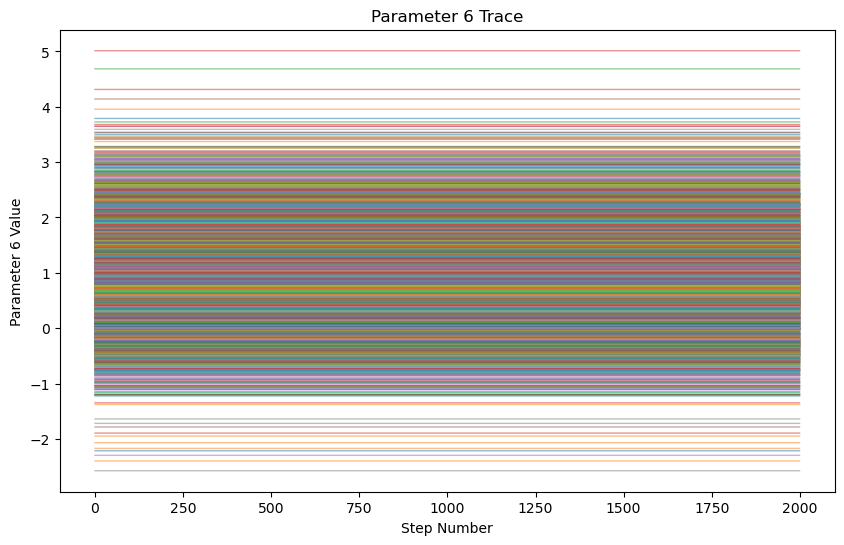

In [8]:
nsteps = sampler_gg.chain.shape[1]
for i in range(6):  # For each parameter
    plt.figure(figsize=(10, 6))
    for chain in sampler_gg.chain[..., i]:
        plt.plot(chain, alpha=0.5, lw=1)
    plt.title(f"Parameter {i+1} Trace")
    plt.xlabel("Step Number")
    plt.ylabel(f"Parameter {i+1} Value")
    plt.savefig(f"/global/u1/z/zhaozhon/Plots/MCMC-parameter{i+1} for g band", dpi=300)
    plt.show()

In [9]:
try:
    tau = sampler_gg.get_autocorr_time(discard=500)
    print("Autocorrelation times:", tau)
except RuntimeError as e:
    print("Failed to compute autocorrelation time:", e)

/global/homes/z/zhaozhon/.local/lib/python3.10/site-packages/emcee/autocorr.py:38: RuntimeWarning: invalid value encountered in true_divide
  acf /= acf[0]


KeyboardInterrupt: 

In [ ]:
effective_sample_size = len(samples_gg) / max(tau)
print("Effective sample size:", effective_sample_size)

In [ ]:
# Autocorrelation plot for Parameter[0]
plot_acf(param_0_samples, lags=40, alpha=0.05, title='Autocorrelation for Parameter[0]')
plt.show()
plot_acf(param_1_samples, lags=40, alpha=0.05, title='Autocorrelation for Parameter[1]')
plt.show()
plot_acf(param_2_samples, lags=40, alpha=0.05, title='Autocorrelation for Parameter[2]')
plt.show()
plot_acf(param_3_samples, lags=40, alpha=0.05, title='Autocorrelation for Parameter[3]')
plt.show()
plot_acf(param_4_samples, lags=40, alpha=0.05, title='Autocorrelation for Parameter[4]')
plt.show()
plot_acf(param_5_samples, lags=40, alpha=0.05, title='Autocorrelation for Parameter[5]')
plt.show()
# Autocorrelation plot for Parameter[3]
plot_acf(param_6_samples, lags=40, alpha=0.05, title='Autocorrelation for Parameter[6]')
plt.show()